In [2]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import pandas as pd
from tqdm import tqdm

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
#----------------------Load the Excel file-----------------------
def load_data(file_path, sheet_name):
    sheet_name = sheet_name
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) 
    # index_tensor = (df['A_position_counted_from_5_end_of_gRNA']).astype(int)
    
    return df, index_tensor

In [4]:
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

In [5]:
print(load_data(file_path='D:/01IscBML/train.xlsx',sheet_name="Train")[1])

0        21
1        23
2        24
3        25
4        27
         ..
27871    27
27872    32
27873    36
27874    27
27875    31
Name: A_position_counted_from_5_end_of_gRNA, Length: 27876, dtype: int32


In [6]:
class BCEFocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=0.6, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1, inplace=False)
        self.episilon = 1e-8
    def forward(self, _input, target):
        pt = _input
        # pt = torch.clamp(_input,0,1)
        alpha = self.alpha
        episilon = self.episilon
        loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt + episilon) - \
               (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt + episilon)
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss

In [7]:
import pandas as pd
import torch

class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name='train_del_keep1700.xlsx'):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor
        self.combined_features, self.tam_onehot, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def __len__(self):
        return len(self.df.shape[0])

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) - 1  # Warning: 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = torch.tensor(list(one_hot_features), dtype=torch.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        TAM_one_hot_features = []
        for idx in self.index_tensor:
            TAM_one_hot = [0] * sequence_length
            # Ensure valid positions for TAM features within sequence_length
            valid_extra_idxs = [i for i in range(36, 40) if 0 <= i < sequence_length]
            for extra_idx in valid_extra_idxs:
                TAM_one_hot[extra_idx] = 2 if extra_idx in range(36, 38) else 3
            TAM_one_hot_features.append(TAM_one_hot)

        index_one_hot_tensor = torch.tensor(index_one_hot_features, dtype=torch.float32).unsqueeze(2)
        TAM_one_hot_features = torch.tensor(TAM_one_hot_features, dtype=torch.float32).unsqueeze(2)

        combined_features = torch.cat((features_tensor, index_one_hot_tensor,TAM_one_hot_features), dim=2)
        # combined_features = torch.cat((features_tensor, index_one_hot_tensor), dim=2)
        return combined_features, TAM_one_hot_features, sequence_length
    
    def label(self):
        #---------------------Prepare labels tensor-----------------------
        labels_tensor = torch.tensor(self.df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels
        return labels_tensor

In [8]:
label_data = FeatureProcessor(file_path='D:/01IscBML/').labels_tensor
combined_features = FeatureProcessor(file_path='D:/01IscBML/').combined_features
print(combined_features[:,36:40,:])

print(combined_features.shape)

tensor([[[1., 0., 0., 0., 0., 2.],
         [0., 1., 0., 0., 0., 2.],
         [0., 0., 0., 1., 0., 3.],
         [0., 0., 0., 1., 0., 3.]],

        [[1., 0., 0., 0., 0., 2.],
         [0., 0., 1., 0., 0., 2.],
         [0., 0., 0., 1., 0., 3.],
         [0., 0., 0., 1., 0., 3.]],

        [[0., 1., 0., 0., 0., 2.],
         [1., 0., 0., 0., 0., 2.],
         [1., 0., 0., 0., 0., 3.],
         [0., 0., 0., 1., 0., 3.]],

        ...,

        [[0., 0., 1., 0., 0., 2.],
         [0., 0., 1., 0., 0., 2.],
         [1., 0., 0., 0., 0., 3.],
         [0., 0., 0., 1., 0., 3.]],

        [[0., 0., 1., 0., 0., 2.],
         [0., 0., 1., 0., 0., 2.],
         [1., 0., 0., 0., 0., 3.],
         [0., 0., 0., 1., 0., 3.]],

        [[0., 0., 1., 0., 0., 2.],
         [0., 0., 1., 0., 0., 2.],
         [1., 0., 0., 0., 0., 3.],
         [0., 0., 0., 1., 0., 3.]]])
torch.Size([11456, 56, 6])


In [9]:
Tam_features = combined_features[:,36:40,:].long()
print(Tam_features.shape)
print(Tam_features)

torch.Size([11456, 4, 6])
tensor([[[1, 0, 0, 0, 0, 2],
         [0, 1, 0, 0, 0, 2],
         [0, 0, 0, 1, 0, 3],
         [0, 0, 0, 1, 0, 3]],

        [[1, 0, 0, 0, 0, 2],
         [0, 0, 1, 0, 0, 2],
         [0, 0, 0, 1, 0, 3],
         [0, 0, 0, 1, 0, 3]],

        [[0, 1, 0, 0, 0, 2],
         [1, 0, 0, 0, 0, 2],
         [1, 0, 0, 0, 0, 3],
         [0, 0, 0, 1, 0, 3]],

        ...,

        [[0, 0, 1, 0, 0, 2],
         [0, 0, 1, 0, 0, 2],
         [1, 0, 0, 0, 0, 3],
         [0, 0, 0, 1, 0, 3]],

        [[0, 0, 1, 0, 0, 2],
         [0, 0, 1, 0, 0, 2],
         [1, 0, 0, 0, 0, 3],
         [0, 0, 0, 1, 0, 3]],

        [[0, 0, 1, 0, 0, 2],
         [0, 0, 1, 0, 0, 2],
         [1, 0, 0, 0, 0, 3],
         [0, 0, 0, 1, 0, 3]]])


In [10]:
sequence_length = FeatureProcessor(file_path='D:/01IscBML/').sequence_length

In [11]:
sequence_length

56

In [12]:
#---------------------Prepare labels tensor-----------------------
# labels_tensor = torch.tensor(df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels

#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(combined_features,Tam_features, label_data)

# Turn shuffle to False if you want to keep the predefined order of the data
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # You can adjust the batch size as needed
i= 0
#----------------------Example to check batches---------------------
for i, (batch_features,batch_Tam_features, batch_labels) in enumerate(dataloader):
    print("Batch", i)
    # print(batch_features.requires_grad)
    # print("Features Batch Shape:", batch_features[:,36:40,:])  # (batch_size, sequence_length, channel_size)
    print("Tam_features Batch Shape:", batch_Tam_features.shape)  # (batch_size, sequence_length, channel_size)
    print("Labels Batch Shape:", batch_labels[20])  # (batch_size, 1)
    i+=1
    if i == 2:
        break


Batch 0
Tam_features Batch Shape: torch.Size([32, 4, 6])
Labels Batch Shape: tensor([0.0935])
Batch 1
Tam_features Batch Shape: torch.Size([32, 4, 6])
Labels Batch Shape: tensor([0.3426])


In [13]:
import torch
import torch.nn as nn

class TAMEnhancer(nn.Module):
    def __init__(self, one_hot_dim, embedding_dim, feature_dim):
        super(TAMEnhancer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=one_hot_dim, embedding_dim=embedding_dim)
        self.linear = nn.Linear(embedding_dim, feature_dim) # lower dimensionality
        self.relu = nn.ReLU()

    def forward(self, tam_indices):
        """
        tam_indices: input shape (batch_size, sequence_length, feature_dim)
        """
        # embedding for the TAM features
        batch_size, sequence_length, feature_dim = tam_indices.shape  # batch_size = 64, sequence_length = 4, feature_dim = 6
        # print("sequence_length:", sequence_length, "feature_dim:", feature_dim) # sequence_length: 4 feature_dim: 6
        tam_indices_flat = tam_indices.view(-1, feature_dim)  #flatten the formal two dimension ，shape:(batch_size * sequence_length, feature_dim)

        # embedding
        tam_embedded = self.embedding(tam_indices_flat.long())  # 形状为 (batch_size * sequence_length, feature_dim, embedding_dim)
        tam_embedded = tam_embedded.mean(dim=-2)  # aggregate the embeddings of the same position

        # lower dimensionality
        tam_features = self.linear(tam_embedded)  # 形状为 (batch_size * sequence_length, feature_dim)
        tam_features = self.relu(tam_features)#[256,6]

        tam_features = tam_features.view(batch_size, feature_dim,-1)  # (batch_size, sequence_length, feature_dim) = (64, 4, 4)
        tam_features = tam_features.permute(0, 2, 1)
        # print("tam_features.shape:", tam_features.shape) 

        return tam_features


In [14]:
class LocalCNN(nn.Module):
    def __init__(self, sequence_length, tam_one_hot_dim=4, tam_embedding_dim=4, kernel_size=21):
        super(LocalCNN, self).__init__()

        # TAMEnhancer
        self.tam_enhancer = TAMEnhancer(one_hot_dim=tam_one_hot_dim, embedding_dim=tam_embedding_dim, feature_dim=6)
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=6 , out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=kernel_size // 2)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1)
        self.dropout = nn.Dropout(0.5)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x, tam_indices):
        # Enhance TAM features


        tam_features = self.tam_enhancer(tam_indices)  # (batch_size, sequence_length, embedding_dim)
        # print(tam_features.shape)
        # print(x.shape)
        # Concatenate TAM features with the input sequence
        x = torch.cat((x, tam_features), dim=1)  # (batch_size, sequence_length, 6 + tam_embedding_dim)

        # Input permutation for Conv1d
        x = x.permute(0, 2, 1)  # (batch_size, 12 + tam_embedding_dim, sequence_length)
        
        # Convolutional block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        # Convolutional block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        
        # Convolutional block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        
        # Global average pooling
        x = self.global_pool(x).squeeze(-1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.leaky_relu(x)
        
        x = self.fc3(x)
        x = self.hardtanh(x)
        
        return x


In [15]:
#------------------split train&validation dataset---------------------
from torch.utils.data import random_split, DataLoader

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size) 

val_size = dataset_size - train_size  
print(val_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False, drop_last=True)    


#------------------pred dataset---------------------
test_label_data = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_del_keep1700.xlsx').labels_tensor
test_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_del_keep1700.xlsx').combined_features
test_Tam_features = test_combined_features[:,36:40,:].long()
#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(test_combined_features, test_Tam_features, test_label_data)
testset_length = len(dataset)
print(testset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
test_dataloader = DataLoader(dataset, batch_size=testset_length, shuffle=False, drop_last=True)

2292
2864


In [16]:
# #------------------split train&validation dataset---------------------
# from torch.utils.data import random_split, DataLoader

# dataset_size = len(dataset)
# train_size = int(0.8 * dataset_size) 

# val_size = dataset_size - train_size  
# print(val_size)

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False, drop_last=True)    

# for i, train_data in enumerate(train_dataloader):
#     print("Batch", i)
#     channel = train_data[0].shape[2]
#     print("Features Batch Shape:", train_data[0].shape)  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", train_data[1].shape)  # (batch_size, 1)
#     print("Channel Size:", channel)
#     i+=1
#     if i == 2:
#         break

Epoch 1/150: 100%|██████████| 143/143 [00:02<00:00, 57.92it/s] 


Model saved with Pearson correlation: 0.6370
Epoch [1/150]
Training Loss: 0.0491
Validation Pearson Correlation: 0.6370


Epoch 2/150: 100%|██████████| 143/143 [00:00<00:00, 254.36it/s]


Model saved with Pearson correlation: 0.6911
Epoch [2/150]
Training Loss: 0.0339
Validation Pearson Correlation: 0.6911


Epoch 3/150: 100%|██████████| 143/143 [00:00<00:00, 256.38it/s]


Model saved with Pearson correlation: 0.7231
Epoch [3/150]
Training Loss: 0.0287
Validation Pearson Correlation: 0.7231


Epoch 4/150: 100%|██████████| 143/143 [00:00<00:00, 247.77it/s]


Model saved with Pearson correlation: 0.7265
Epoch [4/150]
Training Loss: 0.0251
Validation Pearson Correlation: 0.7265


Epoch 5/150: 100%|██████████| 143/143 [00:00<00:00, 261.08it/s]


Model saved with Pearson correlation: 0.7424
Epoch [5/150]
Training Loss: 0.0221
Validation Pearson Correlation: 0.7424


Epoch 6/150: 100%|██████████| 143/143 [00:00<00:00, 254.39it/s]


Model saved with Pearson correlation: 0.7595
Epoch [6/150]
Training Loss: 0.0192
Validation Pearson Correlation: 0.7595


Epoch 7/150: 100%|██████████| 143/143 [00:00<00:00, 257.35it/s]


Model saved with Pearson correlation: 0.7595
Epoch [7/150]
Training Loss: 0.0156
Validation Pearson Correlation: 0.7467


Epoch 8/150: 100%|██████████| 143/143 [00:00<00:00, 254.38it/s]


Model saved with Pearson correlation: 0.7595
Epoch [8/150]
Training Loss: 0.0122
Validation Pearson Correlation: 0.7595


Epoch 9/150: 100%|██████████| 143/143 [00:00<00:00, 227.00it/s]


Model saved with Pearson correlation: 0.7785
Epoch [9/150]
Training Loss: 0.0103
Validation Pearson Correlation: 0.7785


Epoch 10/150: 100%|██████████| 143/143 [00:00<00:00, 231.94it/s]


Model saved with Pearson correlation: 0.7801
Epoch [10/150]
Training Loss: 0.0089
Validation Pearson Correlation: 0.7801


Epoch 11/150: 100%|██████████| 143/143 [00:00<00:00, 237.31it/s]


Model saved with Pearson correlation: 0.7801
Epoch [11/150]
Training Loss: 0.0185
Validation Pearson Correlation: 0.6705


Epoch 12/150: 100%|██████████| 143/143 [00:00<00:00, 264.53it/s]


Model saved with Pearson correlation: 0.7801
Epoch [12/150]
Training Loss: 0.0181
Validation Pearson Correlation: 0.6627


Epoch 13/150: 100%|██████████| 143/143 [00:00<00:00, 267.46it/s]


Model saved with Pearson correlation: 0.7801
Epoch [13/150]
Training Loss: 0.0155
Validation Pearson Correlation: 0.7436


Epoch 14/150: 100%|██████████| 143/143 [00:00<00:00, 281.53it/s]


Model saved with Pearson correlation: 0.7801
Epoch [14/150]
Training Loss: 0.0149
Validation Pearson Correlation: 0.7051


Epoch 15/150: 100%|██████████| 143/143 [00:00<00:00, 269.96it/s]


Model saved with Pearson correlation: 0.7801
Epoch [15/150]
Training Loss: 0.0146
Validation Pearson Correlation: 0.7388


Epoch 16/150: 100%|██████████| 143/143 [00:00<00:00, 283.60it/s]


Model saved with Pearson correlation: 0.7801
Epoch [16/150]
Training Loss: 0.0122
Validation Pearson Correlation: 0.7572


Epoch 17/150: 100%|██████████| 143/143 [00:00<00:00, 228.31it/s]


Model saved with Pearson correlation: 0.7801
Epoch [17/150]
Training Loss: 0.0108
Validation Pearson Correlation: 0.6568


Epoch 18/150: 100%|██████████| 143/143 [00:00<00:00, 243.85it/s]


Model saved with Pearson correlation: 0.7801
Epoch [18/150]
Training Loss: 0.0094
Validation Pearson Correlation: 0.7467


Epoch 19/150: 100%|██████████| 143/143 [00:00<00:00, 278.35it/s]


Model saved with Pearson correlation: 0.7801
Epoch [19/150]
Training Loss: 0.0084
Validation Pearson Correlation: 0.6579


Epoch 20/150: 100%|██████████| 143/143 [00:00<00:00, 282.02it/s]


Model saved with Pearson correlation: 0.7805
Epoch [20/150]
Training Loss: 0.0084
Validation Pearson Correlation: 0.7805


Epoch 21/150: 100%|██████████| 143/143 [00:00<00:00, 276.06it/s]


Model saved with Pearson correlation: 0.7805
Epoch [21/150]
Training Loss: 0.0068
Validation Pearson Correlation: 0.7559


Epoch 22/150: 100%|██████████| 143/143 [00:00<00:00, 260.79it/s]


Model saved with Pearson correlation: 0.7805
Epoch [22/150]
Training Loss: 0.0059
Validation Pearson Correlation: 0.7379


Epoch 23/150: 100%|██████████| 143/143 [00:00<00:00, 264.50it/s]


Model saved with Pearson correlation: 0.7805
Epoch [23/150]
Training Loss: 0.0057
Validation Pearson Correlation: 0.7694


Epoch 24/150: 100%|██████████| 143/143 [00:00<00:00, 261.37it/s]


Model saved with Pearson correlation: 0.7868
Epoch [24/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7868


Epoch 25/150: 100%|██████████| 143/143 [00:00<00:00, 263.69it/s]


Model saved with Pearson correlation: 0.7870
Epoch [25/150]
Training Loss: 0.0045
Validation Pearson Correlation: 0.7870


Epoch 26/150: 100%|██████████| 143/143 [00:00<00:00, 247.08it/s]


Model saved with Pearson correlation: 0.7870
Epoch [26/150]
Training Loss: 0.0038
Validation Pearson Correlation: 0.7844


Epoch 27/150: 100%|██████████| 143/143 [00:00<00:00, 269.19it/s]


Model saved with Pearson correlation: 0.7922
Epoch [27/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7922


Epoch 28/150: 100%|██████████| 143/143 [00:00<00:00, 269.29it/s]


Model saved with Pearson correlation: 0.7953
Epoch [28/150]
Training Loss: 0.0035
Validation Pearson Correlation: 0.7953


Epoch 29/150: 100%|██████████| 143/143 [00:00<00:00, 237.66it/s]


Model saved with Pearson correlation: 0.7974
Epoch [29/150]
Training Loss: 0.0032
Validation Pearson Correlation: 0.7974


Epoch 30/150: 100%|██████████| 143/143 [00:00<00:00, 260.90it/s]


Model saved with Pearson correlation: 0.7974
Epoch [30/150]
Training Loss: 0.0029
Validation Pearson Correlation: 0.7968


Epoch 31/150: 100%|██████████| 143/143 [00:00<00:00, 267.24it/s]


Model saved with Pearson correlation: 0.7974
Epoch [31/150]
Training Loss: 0.0140
Validation Pearson Correlation: 0.7529


Epoch 32/150: 100%|██████████| 143/143 [00:00<00:00, 261.22it/s]


Model saved with Pearson correlation: 0.7974
Epoch [32/150]
Training Loss: 0.0130
Validation Pearson Correlation: 0.6752


Epoch 33/150: 100%|██████████| 143/143 [00:00<00:00, 265.85it/s]


Model saved with Pearson correlation: 0.7974
Epoch [33/150]
Training Loss: 0.0118
Validation Pearson Correlation: 0.7346


Epoch 34/150: 100%|██████████| 143/143 [00:00<00:00, 265.22it/s]


Model saved with Pearson correlation: 0.7974
Epoch [34/150]
Training Loss: 0.0103
Validation Pearson Correlation: 0.7558


Epoch 35/150: 100%|██████████| 143/143 [00:00<00:00, 251.03it/s]


Model saved with Pearson correlation: 0.7974
Epoch [35/150]
Training Loss: 0.0102
Validation Pearson Correlation: 0.6418


Epoch 36/150: 100%|██████████| 143/143 [00:00<00:00, 245.63it/s]


Model saved with Pearson correlation: 0.7974
Epoch [36/150]
Training Loss: 0.0096
Validation Pearson Correlation: 0.7558


Epoch 37/150: 100%|██████████| 143/143 [00:00<00:00, 240.02it/s]


Model saved with Pearson correlation: 0.7974
Epoch [37/150]
Training Loss: 0.0085
Validation Pearson Correlation: 0.7624


Epoch 38/150: 100%|██████████| 143/143 [00:00<00:00, 265.00it/s]


Model saved with Pearson correlation: 0.7974
Epoch [38/150]
Training Loss: 0.0080
Validation Pearson Correlation: 0.7724


Epoch 39/150: 100%|██████████| 143/143 [00:00<00:00, 256.70it/s]


Model saved with Pearson correlation: 0.7974
Epoch [39/150]
Training Loss: 0.0076
Validation Pearson Correlation: 0.7710


Epoch 40/150: 100%|██████████| 143/143 [00:00<00:00, 250.32it/s]


Model saved with Pearson correlation: 0.7974
Epoch [40/150]
Training Loss: 0.0070
Validation Pearson Correlation: 0.7800


Epoch 41/150: 100%|██████████| 143/143 [00:00<00:00, 245.96it/s]


Model saved with Pearson correlation: 0.7974
Epoch [41/150]
Training Loss: 0.0071
Validation Pearson Correlation: 0.6503


Epoch 42/150: 100%|██████████| 143/143 [00:00<00:00, 254.94it/s]


Model saved with Pearson correlation: 0.7974
Epoch [42/150]
Training Loss: 0.0070
Validation Pearson Correlation: 0.7915


Epoch 43/150: 100%|██████████| 143/143 [00:00<00:00, 249.68it/s]


Model saved with Pearson correlation: 0.7974
Epoch [43/150]
Training Loss: 0.0061
Validation Pearson Correlation: 0.7867


Epoch 44/150: 100%|██████████| 143/143 [00:00<00:00, 260.75it/s]


Model saved with Pearson correlation: 0.7974
Epoch [44/150]
Training Loss: 0.0058
Validation Pearson Correlation: 0.7662


Epoch 45/150: 100%|██████████| 143/143 [00:00<00:00, 247.79it/s]


Model saved with Pearson correlation: 0.7974
Epoch [45/150]
Training Loss: 0.0058
Validation Pearson Correlation: 0.6456


Epoch 46/150: 100%|██████████| 143/143 [00:00<00:00, 252.52it/s]


Model saved with Pearson correlation: 0.7974
Epoch [46/150]
Training Loss: 0.0057
Validation Pearson Correlation: 0.7834


Epoch 47/150: 100%|██████████| 143/143 [00:00<00:00, 246.55it/s]


Model saved with Pearson correlation: 0.7974
Epoch [47/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7933


Epoch 48/150: 100%|██████████| 143/143 [00:00<00:00, 257.34it/s]


Model saved with Pearson correlation: 0.7974
Epoch [48/150]
Training Loss: 0.0046
Validation Pearson Correlation: 0.7701


Epoch 49/150: 100%|██████████| 143/143 [00:00<00:00, 247.43it/s]


Model saved with Pearson correlation: 0.7974
Epoch [49/150]
Training Loss: 0.0045
Validation Pearson Correlation: 0.7935


Epoch 50/150: 100%|██████████| 143/143 [00:00<00:00, 248.20it/s]


Model saved with Pearson correlation: 0.7974
Epoch [50/150]
Training Loss: 0.0043
Validation Pearson Correlation: 0.7756


Epoch 51/150: 100%|██████████| 143/143 [00:00<00:00, 252.30it/s]


Model saved with Pearson correlation: 0.7974
Epoch [51/150]
Training Loss: 0.0041
Validation Pearson Correlation: 0.7772


Epoch 52/150: 100%|██████████| 143/143 [00:00<00:00, 249.17it/s]


Model saved with Pearson correlation: 0.7974
Epoch [52/150]
Training Loss: 0.0041
Validation Pearson Correlation: 0.7950


Epoch 53/150: 100%|██████████| 143/143 [00:00<00:00, 259.11it/s]


Model saved with Pearson correlation: 0.7974
Epoch [53/150]
Training Loss: 0.0037
Validation Pearson Correlation: 0.7900


Epoch 54/150: 100%|██████████| 143/143 [00:00<00:00, 260.77it/s]


Model saved with Pearson correlation: 0.7974
Epoch [54/150]
Training Loss: 0.0031
Validation Pearson Correlation: 0.7789


Epoch 55/150: 100%|██████████| 143/143 [00:00<00:00, 258.88it/s]


Model saved with Pearson correlation: 0.7974
Epoch [55/150]
Training Loss: 0.0032
Validation Pearson Correlation: 0.7902


Epoch 56/150: 100%|██████████| 143/143 [00:00<00:00, 226.53it/s]


Model saved with Pearson correlation: 0.7992
Epoch [56/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.7992


Epoch 57/150: 100%|██████████| 143/143 [00:00<00:00, 230.56it/s]


Model saved with Pearson correlation: 0.7992
Epoch [57/150]
Training Loss: 0.0028
Validation Pearson Correlation: 0.7841


Epoch 58/150: 100%|██████████| 143/143 [00:00<00:00, 214.83it/s]


Model saved with Pearson correlation: 0.8026
Epoch [58/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8026


Epoch 59/150: 100%|██████████| 143/143 [00:00<00:00, 226.62it/s]


Model saved with Pearson correlation: 0.8026
Epoch [59/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8012


Epoch 60/150: 100%|██████████| 143/143 [00:00<00:00, 227.08it/s]


Model saved with Pearson correlation: 0.8026
Epoch [60/150]
Training Loss: 0.0024
Validation Pearson Correlation: 0.7960


Epoch 61/150: 100%|██████████| 143/143 [00:00<00:00, 239.30it/s]


Model saved with Pearson correlation: 0.8055
Epoch [61/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8055


Epoch 62/150: 100%|██████████| 143/143 [00:00<00:00, 237.82it/s]


Model saved with Pearson correlation: 0.8055
Epoch [62/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8051


Epoch 63/150: 100%|██████████| 143/143 [00:00<00:00, 238.61it/s]


Model saved with Pearson correlation: 0.8055
Epoch [63/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8013


Epoch 64/150: 100%|██████████| 143/143 [00:00<00:00, 230.94it/s]


Model saved with Pearson correlation: 0.8055
Epoch [64/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7970


Epoch 65/150: 100%|██████████| 143/143 [00:00<00:00, 235.13it/s]


Model saved with Pearson correlation: 0.8055
Epoch [65/150]
Training Loss: 0.0018
Validation Pearson Correlation: 0.8049


Epoch 66/150: 100%|██████████| 143/143 [00:00<00:00, 238.04it/s]


Model saved with Pearson correlation: 0.8058
Epoch [66/150]
Training Loss: 0.0018
Validation Pearson Correlation: 0.8058


Epoch 67/150: 100%|██████████| 143/143 [00:00<00:00, 249.86it/s]


Model saved with Pearson correlation: 0.8058
Epoch [67/150]
Training Loss: 0.0018
Validation Pearson Correlation: 0.8030


Epoch 68/150: 100%|██████████| 143/143 [00:00<00:00, 264.31it/s]


Model saved with Pearson correlation: 0.8058
Epoch [68/150]
Training Loss: 0.0017
Validation Pearson Correlation: 0.8058


Epoch 69/150: 100%|██████████| 143/143 [00:00<00:00, 264.25it/s]


Model saved with Pearson correlation: 0.8058
Epoch [69/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8052


Epoch 70/150: 100%|██████████| 143/143 [00:00<00:00, 266.62it/s]


Model saved with Pearson correlation: 0.8058
Epoch [70/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8055


Epoch 71/150: 100%|██████████| 143/143 [00:00<00:00, 264.36it/s]


Model saved with Pearson correlation: 0.8058
Epoch [71/150]
Training Loss: 0.0156
Validation Pearson Correlation: 0.6821


Epoch 72/150: 100%|██████████| 143/143 [00:00<00:00, 270.67it/s]


Model saved with Pearson correlation: 0.8058
Epoch [72/150]
Training Loss: 0.0141
Validation Pearson Correlation: 0.7238


Epoch 73/150: 100%|██████████| 143/143 [00:00<00:00, 265.93it/s]


Model saved with Pearson correlation: 0.8058
Epoch [73/150]
Training Loss: 0.0104
Validation Pearson Correlation: 0.7709


Epoch 74/150: 100%|██████████| 143/143 [00:00<00:00, 260.32it/s]


Model saved with Pearson correlation: 0.8058
Epoch [74/150]
Training Loss: 0.0080
Validation Pearson Correlation: 0.7431


Epoch 75/150: 100%|██████████| 143/143 [00:00<00:00, 268.40it/s]


Model saved with Pearson correlation: 0.8058
Epoch [75/150]
Training Loss: 0.0078
Validation Pearson Correlation: 0.7808


Epoch 76/150: 100%|██████████| 143/143 [00:00<00:00, 255.62it/s]


Model saved with Pearson correlation: 0.8058
Epoch [76/150]
Training Loss: 0.0081
Validation Pearson Correlation: 0.7541


Epoch 77/150: 100%|██████████| 143/143 [00:00<00:00, 263.54it/s]


Model saved with Pearson correlation: 0.8058
Epoch [77/150]
Training Loss: 0.0074
Validation Pearson Correlation: 0.7388


Epoch 78/150: 100%|██████████| 143/143 [00:00<00:00, 252.76it/s]


Model saved with Pearson correlation: 0.8058
Epoch [78/150]
Training Loss: 0.0066
Validation Pearson Correlation: 0.7508


Epoch 79/150: 100%|██████████| 143/143 [00:00<00:00, 264.67it/s]


Model saved with Pearson correlation: 0.8058
Epoch [79/150]
Training Loss: 0.0069
Validation Pearson Correlation: 0.7690


Epoch 80/150: 100%|██████████| 143/143 [00:00<00:00, 229.97it/s]


Model saved with Pearson correlation: 0.8058
Epoch [80/150]
Training Loss: 0.0063
Validation Pearson Correlation: 0.7105


Epoch 81/150: 100%|██████████| 143/143 [00:00<00:00, 222.05it/s]


Model saved with Pearson correlation: 0.8058
Epoch [81/150]
Training Loss: 0.0055
Validation Pearson Correlation: 0.7315


Epoch 82/150: 100%|██████████| 143/143 [00:00<00:00, 227.18it/s]


Model saved with Pearson correlation: 0.8058
Epoch [82/150]
Training Loss: 0.0056
Validation Pearson Correlation: 0.7716


Epoch 83/150: 100%|██████████| 143/143 [00:00<00:00, 226.48it/s]


Model saved with Pearson correlation: 0.8058
Epoch [83/150]
Training Loss: 0.0058
Validation Pearson Correlation: 0.7586


Epoch 84/150: 100%|██████████| 143/143 [00:00<00:00, 224.45it/s]


Model saved with Pearson correlation: 0.8058
Epoch [84/150]
Training Loss: 0.0055
Validation Pearson Correlation: 0.7119


Epoch 85/150: 100%|██████████| 143/143 [00:00<00:00, 230.23it/s]


Model saved with Pearson correlation: 0.8058
Epoch [85/150]
Training Loss: 0.0055
Validation Pearson Correlation: 0.7736


Epoch 86/150: 100%|██████████| 143/143 [00:00<00:00, 236.33it/s]


Model saved with Pearson correlation: 0.8058
Epoch [86/150]
Training Loss: 0.0048
Validation Pearson Correlation: 0.7451


Epoch 87/150: 100%|██████████| 143/143 [00:00<00:00, 232.84it/s]


Model saved with Pearson correlation: 0.8058
Epoch [87/150]
Training Loss: 0.0053
Validation Pearson Correlation: 0.7274


Epoch 88/150: 100%|██████████| 143/143 [00:00<00:00, 233.02it/s]


Model saved with Pearson correlation: 0.8058
Epoch [88/150]
Training Loss: 0.0053
Validation Pearson Correlation: 0.7173


Epoch 89/150: 100%|██████████| 143/143 [00:00<00:00, 238.82it/s]


Model saved with Pearson correlation: 0.8058
Epoch [89/150]
Training Loss: 0.0060
Validation Pearson Correlation: 0.6696


Epoch 90/150: 100%|██████████| 143/143 [00:00<00:00, 255.38it/s]


Model saved with Pearson correlation: 0.8058
Epoch [90/150]
Training Loss: 0.0059
Validation Pearson Correlation: 0.7769


Epoch 91/150: 100%|██████████| 143/143 [00:00<00:00, 265.21it/s]


Model saved with Pearson correlation: 0.8058
Epoch [91/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7607


Epoch 92/150: 100%|██████████| 143/143 [00:00<00:00, 276.06it/s]


Model saved with Pearson correlation: 0.8058
Epoch [92/150]
Training Loss: 0.0052
Validation Pearson Correlation: 0.7772


Epoch 93/150: 100%|██████████| 143/143 [00:00<00:00, 235.72it/s]


Model saved with Pearson correlation: 0.8058
Epoch [93/150]
Training Loss: 0.0052
Validation Pearson Correlation: 0.7891


Epoch 94/150: 100%|██████████| 143/143 [00:00<00:00, 225.72it/s]


Model saved with Pearson correlation: 0.8058
Epoch [94/150]
Training Loss: 0.0047
Validation Pearson Correlation: 0.7790


Epoch 95/150: 100%|██████████| 143/143 [00:00<00:00, 223.79it/s]


Model saved with Pearson correlation: 0.8058
Epoch [95/150]
Training Loss: 0.0042
Validation Pearson Correlation: 0.7832


Epoch 96/150: 100%|██████████| 143/143 [00:00<00:00, 224.99it/s]


Model saved with Pearson correlation: 0.8058
Epoch [96/150]
Training Loss: 0.0041
Validation Pearson Correlation: 0.7918


Epoch 97/150: 100%|██████████| 143/143 [00:00<00:00, 224.05it/s]


Model saved with Pearson correlation: 0.8058
Epoch [97/150]
Training Loss: 0.0045
Validation Pearson Correlation: 0.7453


Epoch 98/150: 100%|██████████| 143/143 [00:00<00:00, 222.52it/s]


Model saved with Pearson correlation: 0.8058
Epoch [98/150]
Training Loss: 0.0047
Validation Pearson Correlation: 0.7587


Epoch 99/150: 100%|██████████| 143/143 [00:00<00:00, 224.32it/s]


Model saved with Pearson correlation: 0.8058
Epoch [99/150]
Training Loss: 0.0042
Validation Pearson Correlation: 0.7886


Epoch 100/150: 100%|██████████| 143/143 [00:00<00:00, 265.09it/s]


Model saved with Pearson correlation: 0.8058
Epoch [100/150]
Training Loss: 0.0043
Validation Pearson Correlation: 0.8037


Epoch 101/150: 100%|██████████| 143/143 [00:00<00:00, 280.14it/s]


Model saved with Pearson correlation: 0.8058
Epoch [101/150]
Training Loss: 0.0040
Validation Pearson Correlation: 0.7781


Epoch 102/150: 100%|██████████| 143/143 [00:00<00:00, 278.81it/s]


Model saved with Pearson correlation: 0.8058
Epoch [102/150]
Training Loss: 0.0038
Validation Pearson Correlation: 0.7842


Epoch 103/150: 100%|██████████| 143/143 [00:00<00:00, 235.41it/s]


Model saved with Pearson correlation: 0.8058
Epoch [103/150]
Training Loss: 0.0044
Validation Pearson Correlation: 0.7924


Epoch 104/150: 100%|██████████| 143/143 [00:00<00:00, 234.81it/s]


Model saved with Pearson correlation: 0.8058
Epoch [104/150]
Training Loss: 0.0039
Validation Pearson Correlation: 0.7842


Epoch 105/150: 100%|██████████| 143/143 [00:00<00:00, 219.13it/s]


Model saved with Pearson correlation: 0.8058
Epoch [105/150]
Training Loss: 0.0040
Validation Pearson Correlation: 0.7445


Epoch 106/150: 100%|██████████| 143/143 [00:00<00:00, 230.98it/s]


Model saved with Pearson correlation: 0.8058
Epoch [106/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7952


Epoch 107/150: 100%|██████████| 143/143 [00:00<00:00, 232.79it/s]


Model saved with Pearson correlation: 0.8058
Epoch [107/150]
Training Loss: 0.0034
Validation Pearson Correlation: 0.7777


Epoch 108/150: 100%|██████████| 143/143 [00:00<00:00, 239.33it/s]


Model saved with Pearson correlation: 0.8058
Epoch [108/150]
Training Loss: 0.0034
Validation Pearson Correlation: 0.7863


Epoch 109/150: 100%|██████████| 143/143 [00:00<00:00, 234.92it/s]


Model saved with Pearson correlation: 0.8058
Epoch [109/150]
Training Loss: 0.0034
Validation Pearson Correlation: 0.7905


Epoch 110/150: 100%|██████████| 143/143 [00:00<00:00, 269.18it/s]


Model saved with Pearson correlation: 0.8058
Epoch [110/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.7805


Epoch 111/150: 100%|██████████| 143/143 [00:00<00:00, 260.23it/s]


Model saved with Pearson correlation: 0.8058
Epoch [111/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.7714


Epoch 112/150: 100%|██████████| 143/143 [00:00<00:00, 264.09it/s]


Model saved with Pearson correlation: 0.8089
Epoch [112/150]
Training Loss: 0.0027
Validation Pearson Correlation: 0.8089


Epoch 113/150: 100%|██████████| 143/143 [00:00<00:00, 229.08it/s]


Model saved with Pearson correlation: 0.8089
Epoch [113/150]
Training Loss: 0.0028
Validation Pearson Correlation: 0.7964


Epoch 114/150: 100%|██████████| 143/143 [00:00<00:00, 225.32it/s]


Model saved with Pearson correlation: 0.8089
Epoch [114/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.7791


Epoch 115/150: 100%|██████████| 143/143 [00:00<00:00, 255.63it/s]


Model saved with Pearson correlation: 0.8089
Epoch [115/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.7949


Epoch 116/150: 100%|██████████| 143/143 [00:00<00:00, 263.33it/s]


Model saved with Pearson correlation: 0.8089
Epoch [116/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.7991


Epoch 117/150: 100%|██████████| 143/143 [00:00<00:00, 263.97it/s]


Model saved with Pearson correlation: 0.8089
Epoch [117/150]
Training Loss: 0.0027
Validation Pearson Correlation: 0.7875


Epoch 118/150: 100%|██████████| 143/143 [00:00<00:00, 233.51it/s]


Model saved with Pearson correlation: 0.8089
Epoch [118/150]
Training Loss: 0.0024
Validation Pearson Correlation: 0.7948


Epoch 119/150: 100%|██████████| 143/143 [00:00<00:00, 247.33it/s]


Model saved with Pearson correlation: 0.8089
Epoch [119/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8055


Epoch 120/150: 100%|██████████| 143/143 [00:00<00:00, 262.09it/s]


Model saved with Pearson correlation: 0.8089
Epoch [120/150]
Training Loss: 0.0024
Validation Pearson Correlation: 0.8072


Epoch 121/150: 100%|██████████| 143/143 [00:00<00:00, 233.05it/s]


Model saved with Pearson correlation: 0.8089
Epoch [121/150]
Training Loss: 0.0023
Validation Pearson Correlation: 0.8019


Epoch 122/150: 100%|██████████| 143/143 [00:00<00:00, 249.02it/s]


Model saved with Pearson correlation: 0.8089
Epoch [122/150]
Training Loss: 0.0019
Validation Pearson Correlation: 0.8071


Epoch 123/150: 100%|██████████| 143/143 [00:00<00:00, 237.25it/s]


Model saved with Pearson correlation: 0.8089
Epoch [123/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7966


Epoch 124/150: 100%|██████████| 143/143 [00:00<00:00, 231.08it/s]


Model saved with Pearson correlation: 0.8089
Epoch [124/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7887


Epoch 125/150: 100%|██████████| 143/143 [00:00<00:00, 239.91it/s]


Model saved with Pearson correlation: 0.8089
Epoch [125/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7924


Epoch 126/150: 100%|██████████| 143/143 [00:00<00:00, 266.76it/s]


Model saved with Pearson correlation: 0.8089
Epoch [126/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7876


Epoch 127/150: 100%|██████████| 143/143 [00:00<00:00, 264.35it/s]


Model saved with Pearson correlation: 0.8089
Epoch [127/150]
Training Loss: 0.0017
Validation Pearson Correlation: 0.8074


Epoch 128/150: 100%|██████████| 143/143 [00:00<00:00, 251.71it/s]


Model saved with Pearson correlation: 0.8089
Epoch [128/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.7791


Epoch 129/150: 100%|██████████| 143/143 [00:00<00:00, 268.06it/s]


Model saved with Pearson correlation: 0.8089
Epoch [129/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8045


Epoch 130/150: 100%|██████████| 143/143 [00:00<00:00, 263.02it/s]


Model saved with Pearson correlation: 0.8089
Epoch [130/150]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8025


Epoch 131/150: 100%|██████████| 143/143 [00:00<00:00, 272.26it/s]


Model saved with Pearson correlation: 0.8089
Epoch [131/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8063


Epoch 132/150: 100%|██████████| 143/143 [00:00<00:00, 269.52it/s]


Model saved with Pearson correlation: 0.8089
Epoch [132/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8068


Epoch 133/150: 100%|██████████| 143/143 [00:00<00:00, 274.49it/s]


Model saved with Pearson correlation: 0.8089
Epoch [133/150]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8078


Epoch 134/150: 100%|██████████| 143/143 [00:00<00:00, 281.74it/s]


Model saved with Pearson correlation: 0.8089
Epoch [134/150]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8055


Epoch 135/150: 100%|██████████| 143/143 [00:00<00:00, 244.52it/s]


Model saved with Pearson correlation: 0.8089
Epoch [135/150]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8067


Epoch 136/150: 100%|██████████| 143/143 [00:00<00:00, 256.43it/s]


Model saved with Pearson correlation: 0.8089
Epoch [136/150]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8088


Epoch 137/150: 100%|██████████| 143/143 [00:00<00:00, 245.44it/s]


Model saved with Pearson correlation: 0.8089
Epoch [137/150]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8056


Epoch 138/150: 100%|██████████| 143/143 [00:00<00:00, 237.89it/s]


Model saved with Pearson correlation: 0.8089
Epoch [138/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8040


Epoch 139/150: 100%|██████████| 143/143 [00:00<00:00, 229.90it/s]


Model saved with Pearson correlation: 0.8089
Epoch [139/150]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8079


Epoch 140/150: 100%|██████████| 143/143 [00:00<00:00, 239.79it/s]


Model saved with Pearson correlation: 0.8089
Epoch [140/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8041


Epoch 141/150: 100%|██████████| 143/143 [00:00<00:00, 274.68it/s]


Model saved with Pearson correlation: 0.8089
Epoch [141/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8071


Epoch 142/150: 100%|██████████| 143/143 [00:00<00:00, 272.89it/s]


Model saved with Pearson correlation: 0.8089
Epoch [142/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8071


Epoch 143/150: 100%|██████████| 143/143 [00:00<00:00, 278.02it/s]


Model saved with Pearson correlation: 0.8089
Epoch [143/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8072


Epoch 144/150: 100%|██████████| 143/143 [00:00<00:00, 274.04it/s]


Model saved with Pearson correlation: 0.8089
Epoch [144/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8062


Epoch 145/150: 100%|██████████| 143/143 [00:00<00:00, 277.49it/s]


Model saved with Pearson correlation: 0.8089
Epoch [145/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8077


Epoch 146/150: 100%|██████████| 143/143 [00:00<00:00, 264.79it/s]


Model saved with Pearson correlation: 0.8089
Epoch [146/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8071


Epoch 147/150: 100%|██████████| 143/143 [00:00<00:00, 263.56it/s]


Model saved with Pearson correlation: 0.8089
Epoch [147/150]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8075


Epoch 148/150: 100%|██████████| 143/143 [00:00<00:00, 276.51it/s]


Model saved with Pearson correlation: 0.8090
Epoch [148/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8090


Epoch 149/150: 100%|██████████| 143/143 [00:00<00:00, 253.96it/s]


Model saved with Pearson correlation: 0.8090
Epoch [149/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8086


Epoch 150/150: 100%|██████████| 143/143 [00:00<00:00, 229.68it/s]


Model saved with Pearson correlation: 0.8090
Epoch [150/150]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8082


<Figure size 640x480 with 0 Axes>

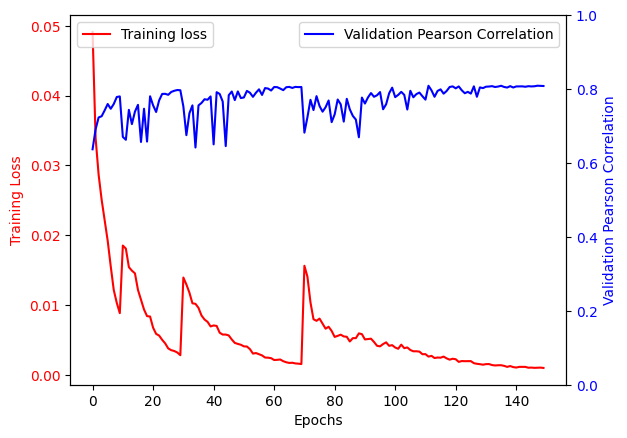

In [17]:
import time
from torchsummary import summary
import os
import random
timestamp = time.strftime('%Y%m%d_%H%M%S')
save_dir = f'D:/01IscBML/logfile/{timestamp}/'
os.mkdir(save_dir)
torch.manual_seed(42)
sequence_length = FeatureProcessor(file_path='D:/01IscBML/').sequence_length
# Initialize the model, loss function, and optimizer
model = LocalCNN(sequence_length=sequence_length)
# criterion = BCEFocalLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.00001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training and validation setup
num_epochs = 150  # Adjust as needed

# Function to calculate Pearson correlation coefficient
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

plot_loss = []
plot_pearson = []
max_r = 0.0
for epoch in range(num_epochs):
    # if epoch == 0:  # Save the architecture only in the first epoch
    #     # for MLP
    #     input_size = sequence_length * channel
    #     model_architecture = summary(model,input_size=(sequence_length,channel))
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_pearson = 0.0  # To accumulate Pearson correlation coefficient for training
    
    # Training loop
    for batch_features,batch_tam_features, batch_labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to appropriate device (e.g., GPU if available)
        batch_features, batch_tam_features, batch_labels = batch_features.to(device), batch_tam_features.to(device), batch_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        model.to(device)
        # Forward pass
        outputs = model(batch_features, batch_tam_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Pearson correlation for the batch
        predicted = outputs.squeeze(1)  # Remove singleton dimension
        actual = batch_labels.squeeze(1)
        train_pearson += pearson_correlation(predicted, actual)

    # Compute average training loss and Pearson correlation for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    plot_loss.append(epoch_loss)
    epoch_train_pearson = train_pearson / len(train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_pearson = 0.0
    with torch.no_grad():
        for val_features, val_tam_features, val_labels in val_dataloader:  # Use a separate validation DataLoader
            val_features, val_tam_features,  val_labels = val_features.to(device),val_tam_features.to(device), val_labels.to(device)
            
            val_outputs = model(val_features,val_tam_features)
            predicted = val_outputs.squeeze(1)
            # print(predicted)
            actual = val_labels.squeeze(1)
            # print(actual)

            # Calculate Pearson correlation for the validation set
            val_pearson += pearson_correlation(predicted, actual)
    
    # Compute average validation Pearson correlation for the epoch
    epoch_val_pearson = val_pearson / len(val_dataloader)
    plot_pearson.append(epoch_val_pearson)

    ##save the model and architecture
    if epoch_val_pearson > max_r:
        max_r = epoch_val_pearson
        model_name = model.__class__.__name__
        save_model_path = f'{save_dir}{model_name}.pth'
        # model_architecture = summary(model, input_size=(sequence_length,channel))
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # 'architecture': model_architecture,
                    # 'lr': optimizer.param_groups[0]['lr'],
                    }, save_model_path)
    scheduler.step()
    # lr = scheduler.get_last_lr()[0]
    print(f"Model saved with Pearson correlation: {max_r:.4f}")

    # Print training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Pearson Correlation: {epoch_val_pearson:.4f}")
    # print(f"lr:{lr:.4f}")

plt.figure()
# plt.switch_backend('agg')
fig, ax1 = plt.subplots()

# model.predict()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='r')
ax1.plot(range(num_epochs), plot_loss, 'r', label='Training loss')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Pearson Correlation', color='b')
ax2.plot(range(num_epochs), plot_pearson, 'b', label='Validation Pearson Correlation')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim(0, 1)
plt.legend()
# plt.show()
file_path = os.path.join(save_dir, 'loss_plot_MLP.png')
plt.savefig(file_path)


In [18]:
###---------test the model----------------
import torch
import pandas as pd

model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
model.eval()
# Initialize variables for tracking
test_results = []  # To store results for each test sample
test_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_features, test_Tam_features, test_labels in test_dataloader:  # Use the test DataLoader
        # Move data to the appropriate device (e.g., CPU)
        test_features, test_labels, test_Tam_features = test_features.to(device), test_labels.to(device), test_Tam_features.to(device)
        print(test_features.shape, test_Tam_features.shape)
        # Perform predictions
        test_outputs = model(test_features, test_Tam_features)
        predicted = test_outputs.squeeze(1)  # Detach to numpy for processing
        actual = test_labels.squeeze(1)

        # Store each prediction with its actual label
        for pred, act in zip(predicted, actual):
            test_results.append({'Predicted': pred.item(), 'Actual': act.item()})
        
        # Calculate Pearson correlation for this batch
        test_pearson += pearson_correlation(predicted, actual)

# Compute average test Pearson correlation
avg_test_pearson = test_pearson / len(test_dataloader)
print(f"Average test Pearson Correlation: {avg_test_pearson}")

# Save test results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(test_results)
test_result_path = f'{save_dir}{timestamp}.csv'
test_result_path2 = f'{save_dir}{timestamp}_2.csv'
results_df.to_csv(f'{save_dir}{timestamp}.csv', index=False)
print("test results saved to 'test_results.csv'.")



torch.Size([2864, 56, 6]) torch.Size([2864, 4, 6])
Average test Pearson Correlation: 0.8109391331672668
test results saved to 'test_results.csv'.


C:\Users\SHO\AppData\Local\Temp\ipykernel_11320\3952504352.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path)['model_state

In [19]:
#------------------predict dataset---------------------
predict_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='test_pred.xlsx').combined_features
predict_Tam_features = predict_combined_features[:,36:40,:].long()
#---------------------Create dataset and dataloader-----------------
pred_dataset = TensorDataset(predict_combined_features, predict_Tam_features)
predictset_length = len(pred_dataset)
print(predictset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
pred_dataloader = DataLoader(pred_dataset, batch_size=predictset_length, shuffle=False, drop_last=True)

44


In [20]:
###---------pred the model----------------
import torch
import pandas as pd


model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
model.eval()
# Initialize variables for tracking
pred_results = []  # To store results for each pred sample
pred_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for pred_features, pred_Tam_features in pred_dataloader:  # Use the pred DataLoader
        # Move data to the appropriate device (e.g., CPU)
        pred_features, pred_Tam_features = pred_features.to(device), pred_Tam_features.to(device)
        print(pred_features.shape,pred_Tam_features.shape)
        # Perform predictions
        pred_outputs = model(pred_features, pred_Tam_features)
        predicted = pred_outputs.squeeze(1)  # Detach to numpy for processing

        # Store each prediction with its actual label
        for pred in predicted:
            pred_results.append({'Predicted': pred.item()})


# Save pred results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(pred_results)
results_df.to_csv(f'{save_dir}{timestamp}pred3.csv', index=False)
print("pred results saved to 'pred_results.csv'.")


torch.Size([44, 56, 6]) torch.Size([44, 4, 6])
pred results saved to 'pred_results.csv'.


C:\Users\SHO\AppData\Local\Temp\ipykernel_11320\319344517.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path)['model_state_

In [21]:
# class Pred_featureProcessor:
#     def __init__(self, file_path='D:/01IscBML/', file_name='IscB_gRNA spacer sequence.xlsx'):
#         self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
#         self.data_path = file_path + file_name
#         self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor

#     def __len__(self):
#         return len(self.df)

#     def load_data(self, data_path):
#         df = pd.read_excel(data_path)
#         index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) - 1  # Warning: 0-indexed
#         return df, index_tensor

#     def sequence_to_one_hot(self, sequence, categories="ATCG"):
#         category_map = {char: idx for idx, char in enumerate(categories)}
#         one_hot = []
#         for char in sequence:
#             one_hot_char = [0] * len(categories)
#             if char in category_map:
#                 one_hot_char[category_map[char]] = 1
#             one_hot.append(one_hot_char)
#         return one_hot

#     def process_row(self, row):
#         sequence = row['Target_site_sequence']
#         sequence_length = len(sequence)
#         one_hot_features = self.sequence_to_one_hot(sequence)

#         features_tensor = torch.tensor(one_hot_features, dtype=torch.float32)
#         print(features_tensor.shape)

#         # Create index one-hot feature
#         index = int(row['A_position_counted_from_5_end_of_gRNA'] + 20 - 1)  # Adjust to 0-indexed
#         index_one_hot = [0] * sequence_length
#         if 0 <= index < sequence_length:
#             index_one_hot[index] = 1

#         # Create TAM one-hot feature
#         TAM_one_hot = [0] * sequence_length
#         valid_extra_idxs = [i for i in range(36, 40) if 0 <= i < sequence_length]
#         for extra_idx in valid_extra_idxs:
#             TAM_one_hot[extra_idx] = 2 if extra_idx in range(36, 38) else 3

#         # Combine features
#         index_one_hot_tensor = torch.tensor(index_one_hot, dtype=torch.float32).unsqueeze(1)
#         print(index_one_hot_tensor.shape)
#         TAM_one_hot_tensor = torch.tensor(TAM_one_hot, dtype=torch.float32).unsqueeze(1)
#         print(TAM_one_hot_tensor.shape)
        
#         combined_features = torch.cat((features_tensor, index_one_hot_tensor, TAM_one_hot_tensor), dim=1)
#         print(combined_features.shape)

#         return combined_features, TAM_one_hot_tensor, sequence_length

In [22]:
# ###---------Predict module----------------
# import torch
# import pandas as pd

# # Load the saved model
# model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
# model.eval()

# # Load the Excel file row by row
# file_path = 'D:/01IscBML/'
# file_name = 'IscB_gRNA spacer sequence.xlsx'
# sheet_name = 'IscB gRNA'
# predict_data = pd.read_excel(file_path+file_name, sheet_name=sheet_name)

# # Initialize variables for storing results
# predict_results = []

# # Iterate through each row in the DataFrame
# with torch.no_grad():
#     feature_processor = Pred_featureProcessor(file_path=file_path, file_name=file_name)
#     for index, row in predict_data.iterrows():
#         # Extract features for the current row
#         predict_combined_features,TAM_one_hot_tensor,sequence_length = feature_processor.process_row(row)
#         predict_Tam_features = predict_combined_features[36:40,:].long()

#         # Perform prediction
#         predict_combined_features = predict_combined_features.to(device)
#         TAM_one_hot_tensor = TAM_one_hot_tensor.to(device)
#         predict_output = model(predict_combined_features, TAM_one_hot_tensor)
#         predicted_value = predict_output.squeeze(1).item()

#         # Append prediction to the results
#         predict_results.append(predicted_value)

# # Update the original DataFrame with predictions
# predict_data['a-to-g%'] = predict_results

# # Save the updated DataFrame with predictions
# output_path = f'{save_dir}{timestamp}_predictions.xlsx'
# predict_data.to_excel(output_path, index=False)

# print(f"Predictions saved to '{output_path}'.")


In [24]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
#output higher efficiency's test correlation

#open the test result file
test_result_2 = pd.read_csv(test_result_path)
#filter all the actural value > 0.2
test_result_2 = test_result_2[test_result_2['Actual'] > 0.2]
test_result_2.to_csv(test_result_path2)

test_values = test_result_2['Predicted']
actual_values = test_result_2['Actual']

# Calculate Pearson correlation
pearson_corr_2 = pearsonr(test_values, actual_values)
spearmanr_2 = spearmanr(test_values, actual_values)[0]
pearson_correlation_2 = pearson_corr_2[0]
print(pearson_correlation_2, spearmanr_2)


0.6345791168555387 0.6212108935688558


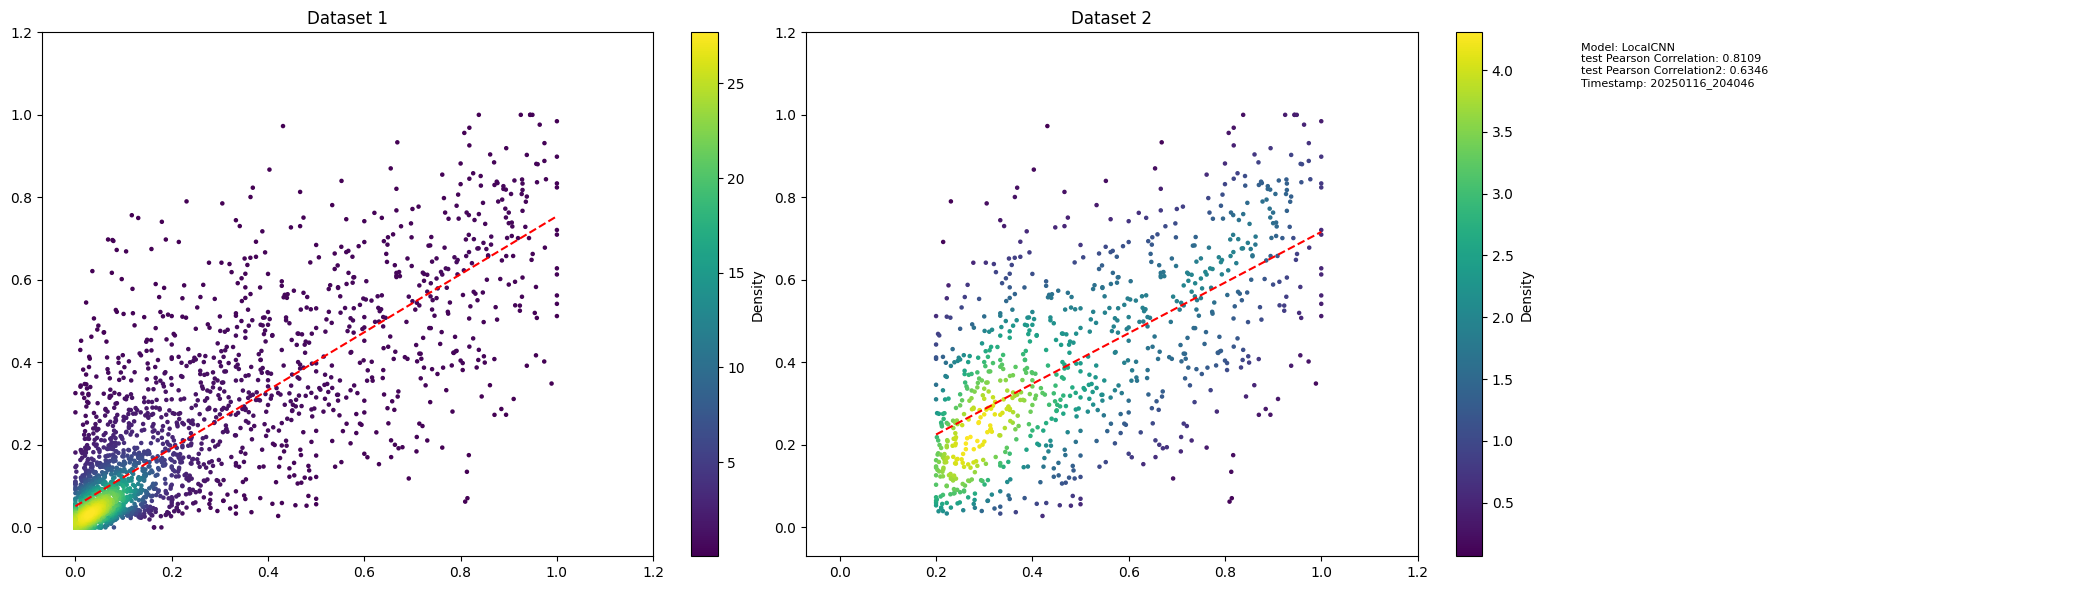

In [25]:
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import io
import contextlib

# Load first dataset
test_results_1 = pd.read_csv(test_result_path)
actual_1 = test_results_1['Actual'].values
predicted_1 = test_results_1['Predicted'].values

# Calculate density for first dataset
xy_1 = np.vstack([actual_1, predicted_1])
density_1 = gaussian_kde(xy_1)(xy_1)
sorted_indices_1 = density_1.argsort()
actual_sorted_1 = actual_1[sorted_indices_1]
predicted_sorted_1 = predicted_1[sorted_indices_1]
density_sorted_1 = density_1[sorted_indices_1]

# Load second dataset
test_results_2 = pd.read_csv(test_result_path2)
actual_2 = test_results_2['Actual'].values
predicted_2 = test_results_2['Predicted'].values

# Calculate density for second dataset
xy_2 = np.vstack([actual_2, predicted_2])
density_2 = gaussian_kde(xy_2)(xy_2)
sorted_indices_2 = density_2.argsort()
actual_sorted_2 = actual_2[sorted_indices_2]
predicted_sorted_2 = predicted_2[sorted_indices_2]
density_sorted_2 = density_2[sorted_indices_2]

# Create the plot
plt.figure(figsize=(21, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1.5,1])

# Plot first dataset
scatter_1 = plt.subplot(gs[0, 0])
scatter_1 = plt.scatter(
    actual_sorted_1,
    predicted_sorted_1,
    c=density_sorted_1,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_1, label='Density')
plt.plot(
    np.unique(actual_1),
    np.poly1d(np.polyfit(actual_1, predicted_1, 1))(np.unique(actual_1)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 1')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Plot second dataset
scatter_2 = plt.subplot(gs[0, 1])
scatter_2 = plt.scatter(
    actual_sorted_2,
    predicted_sorted_2,
    c=density_sorted_2,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_2, label='Density')
plt.plot(
    np.unique(actual_2),
    np.poly1d(np.polyfit(actual_2, predicted_2, 1))(np.unique(actual_2)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 2')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Add the model architecture
ax_text = plt.subplot(gs[0,2])  # Use the second section of the grid
ax_text.axis('off')  # Turn off the axes for the text area
info_text = f"Model: {model.__class__.__name__}\n" \
            f"test Pearson Correlation: {avg_test_pearson:.4f}\n" \
            f"test Pearson Correlation2: {pearson_correlation_2:.4f}\n" \
            f"Timestamp: {timestamp}"

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')

save_path = os.path.join(save_dir, f"{timestamp}_{avg_test_pearson:.4f}.png")
plt.savefig(save_dir+f'{timestamp}_{avg_test_pearson:.4f}.png')
